In [3]:
from importlib import reload
import numpy as np

import src.music.mir
reload(src.music.mir)
import src.music
reload(src.music)
from src.music import MusicInformationRetreiver
from src.speech import SpeechInformationRetreiver
import matplotlib.pyplot as plt

In [4]:
music_path = 'assets/immersiveTrack_249.mp3'
speech_path = 'assets/LANDR-Meditations- Mindful Beathing 15 Mins-Balanced-Medium.mp3'


mir = MusicInformationRetreiver(weights_path='mir_weights/', distance_threshold=0.1)
sir = SpeechInformationRetreiver(
    model_name='stt_en_fastconformer_hybrid_large_streaming_1040ms',
    lookahead_size=1040,
    decoder_type='rnnt',
    device='cpu'
)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//emomusic-msd-musicnn-2.pb`
[NeMo W 2024-07-10 11:52:18 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
      warnings.warn(
    
[NeMo W 2024-07-10 11:52:18 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/tra

[NeMo I 2024-07-10 11:52:21 cloud:58] Found existing object /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo.
[NeMo I 2024-07-10 11:52:21 cloud:64] Re-using file from: /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo
[NeMo I 2024-07-10 11:52:21 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-07-10 11:52:22 mixins:172] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-07-10 11:52:22 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /raid/local//bucket1/tarred_audio_manifest.json
    - - /raid/local//bucket2/tarred_audio_manifest.json
    - - /raid/local//bucket3/tarred_audio_manifest.json
    - - /raid/local//bucket4/tarred_audio_manifest.json
    - - /raid/local//bucket5/tarred_audio_manifest.json
    - - /raid/local//bucket6/tarred_audio_manifest.json
    - - /raid/local//bucket7/tarred_audio_manifest.json
    - - /raid/local//bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 25
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths:
    - - /data2/nemo_asr/nemo_asr_set_3.0//bucket1/audi

[NeMo I 2024-07-10 11:52:22 features:305] PADDING: 0


[NeMo W 2024-07-10 11:52:23 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2024-07-10 11:52:23 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}
[NeMo I 2024-07-10 11:52:23 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-10 11:52:23 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-10 11:52:23 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-10 11:52:23 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-10 11:52:23 save_restore_connector:263] Model EncDecHybridRNNTCTCBPEModel was successfully restored from /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo.
[NeMo I 2024-07-10 11:52:23 hybrid_rnnt_ctc_bpe_models:422] No `decoding_cfg` passed when changing decoding strategy, using internal config
[NeMo I 2024-07-10 11:52:23 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-10 11:52:23 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-10 11:52:23 hybrid_rnnt_ctc_bpe_models:457] Changed decoding strategy of the RNNT decoder to 
    model_type: rnnt
    strategy: greedy_batch
    compute_hypothesis_token_set: false
    preserve_alignments: null
    confidence_cfg:
      preserve_frame_confidence: false
      preserve_token_confidence: false
      preserve_word_confidence: false
      exclude_blank: true
      aggregation: min
      tdt_include_duration: false
      method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        entropy_norm: exp
        temperature: DEPRECATED
    fused_batch_size: null
    compute_timestamps: null
    compute_langs: false
    word_seperator: ' '
    rnnt_timestamp_type: all
    greedy:
      max_symbols_per_step: 10
      preserve_alignments: false
      preserve_frame_confidence: false
      tdt_include_duration_confidence: false
      confidence_method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        en

In [5]:
asr_res = sir.recognize_file(speech_path)
mir_res = mir.recognize_file(music_path)

  0%|          | 0/805 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

2024-07-10 11:57:12.998414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`


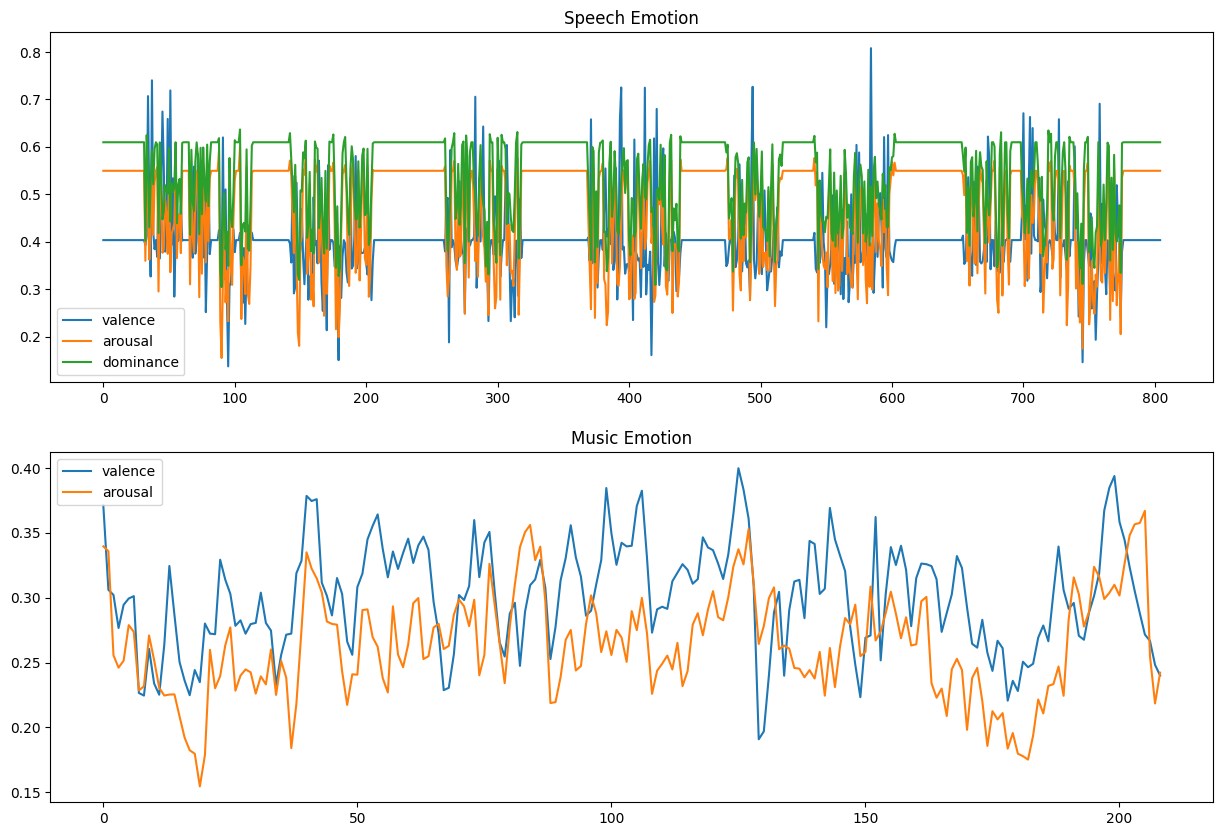

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title('Speech Emotion')
plt.plot(asr_res['valence'], label='valence')
plt.plot(asr_res['arousal'], label='arousal')
plt.plot(asr_res['dominance'], label='dominance')
plt.legend()

plt.subplot(212)
plt.title('Music Emotion')
plt.plot(mir_res['valence'], label='valence')
plt.plot(mir_res['arousal'], label='arousal')
plt.legend()

In [7]:
import seaborn as sns
from collections import Counter


def extract_segments(speech_res, music_res, genre_classes, inst_classes, threshold=0.3):
    prev = 0
    bounds = np.append(music_res['segments'][1:], music_res['length'])
    segments = []
    n_speech_emo = len(speech_res['emotion_labels'])
    n_speech_emo_dim = len(speech_res['valence'])
    n_music_emo = len(music_res['valence'])
    n_music_tag = len(music_res['genre'])
    for end in bounds:
        seg = {'start' : prev, 'end': end, 'duration': end - prev, 'music': {}, 'speech': {}}

        ## Speech
        idx1 = int(prev * n_speech_emo // speech_res['length']) + 1
        idx2 = int(end * n_speech_emo // speech_res['length'])
    
        seg['speech']['emotion_label'] = Counter(speech_res['emotion_labels'][idx1:idx2]).most_common(n=1)[0][0]
    
        idx1 = int(prev * n_speech_emo_dim // speech_res['length']) + 1
        idx2 = int(end * n_speech_emo_dim // speech_res['length'])
        for dim in ['valence', 'arousal', 'dominance']:
            seg['speech'][dim] = speech_res[dim][idx1:idx2].mean()
    
        idx1 = int(prev * n_music_emo // music_res['length']) + 1
        idx2 = int(end * n_music_emo // music_res['length'])
        for dim in ['valence', 'arousal']:
            seg['music'][dim] = music_res[dim][idx1:idx2].mean()
    
        idx1 = int(prev * n_music_emo // music_res['length']) + 1
        idx2 = int(end * n_music_emo // music_res['length'])
        
        genre = music_res['genre'][idx1:idx2].mean(axis=0)
        genre_ids = np.where(genre > threshold)[0]
        seg['music']['genre'] = dict([(genre_classes[gid], genre[gid]) for gid in genre_ids])
        
        instrument = music_res['instrument'][idx1:idx2].mean(axis=0)
        inst_ids = np.where(instrument > threshold)[0]
        seg['music']['instrument'] = dict([(inst_classes[iid], instrument[iid]) for iid in inst_ids])
    
        
        beats = music_res['beats'][:, 0]
        n_beats = sum((beats > prev) & (beats < end))
        seg['music']['tempo'] = n_beats * 60 // (end - prev)
        
        segments += [seg]
        prev = end
    return segments

In [8]:
segments = extract_segments(asr_res, mir_res, mir.genre_classes, mir.inst_classes)

In [9]:
segments

[{'start': 0,
  'end': 67.488,
  'duration': 67.488,
  'music': {'valence': 0.27742797,
   'arousal': 0.23842731,
   'genre': {'ambient': 0.7544448, 'electronic': 0.4119216},
   'instrument': {'synthesizer': 0.5706674},
   'tempo': 172.0},
  'speech': {'emotion_label': 'neu',
   'valence': 0.43581986831406416,
   'arousal': 0.5021909500582743,
   'dominance': 0.5679751205242286}},
 {'start': 67.488,
  'end': 146.528,
  'duration': 79.03999999999999,
  'music': {'valence': 0.3079267,
   'arousal': 0.2790053,
   'genre': {'ambient': 0.7490427, 'electronic': 0.41484684},
   'instrument': {'synthesizer': 0.6840571},
   'tempo': 157.0},
  'speech': {'emotion_label': 'neu',
   'valence': 0.39926734955414483,
   'arousal': 0.4674539280974347,
   'dominance': 0.5420497094375499}},
 {'start': 146.528,
  'end': 287.84,
  'duration': 141.31199999999998,
  'music': {'valence': 0.31193867,
   'arousal': 0.2666391,
   'genre': {'ambient': 0.6955065, 'electronic': 0.39392275},
   'instrument': {'synt

In [10]:
asr_res['text']

"hello and welcome to your resonance r xes guided meditation hi mandrew i am here to guide you through a transformative journey where we will be embracing the powerful practice of mindfulness focusing on our breath this practice is designed with you and mine aiming to bring moments of peace relaxation and clarity let's start by finding a comfortable spot where you can sit or lie down ensuring that distractions are minimal once you've settled that your arms rest naturally and have your legs in a relaxed position has we embark on this journey begin by taking a few profound and rejuvenating breaths inhal deeply feeling your chest and abdomen rise and then exhale slowly letting go if any strains or worries with every breath do this a couple times immersing yourself in this present moment disconnecting from any external stresses feel the connection between your body and its resting place and the grounding sensation of your feet touching the floor our breath will be the anchor of today's med

In [11]:
import torch
from muse import PipelineMuse

pipe = PipelineMuse.from_pretrained("openMUSE/muse-512-finetuned")
# pipe.transformer.enable_xformers_memory_efficient_attention()

[NeMo W 2024-07-10 11:58:10 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
      torch.utils._pytree._register_pytree_node(
    
[NeMo W 2024-07-10 11:58:10 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
      warnings.warn(
    


[NeMo W 2024-07-10 11:58:16 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn(
    


  0%|          | 0/16 [00:00<?, ?it/s]

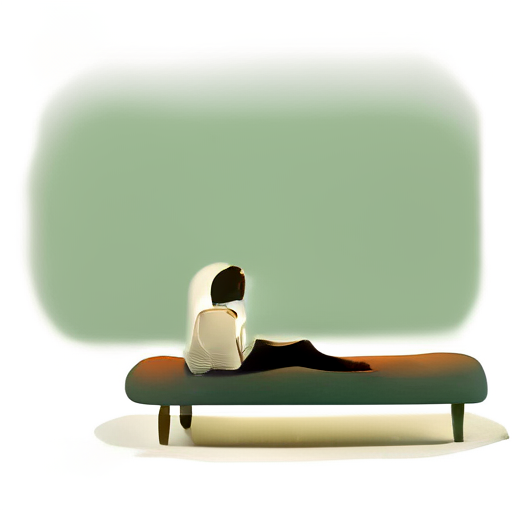

In [12]:
images = pipe(
  asr_res['text'], timesteps=16, guidance_scale=10, transformer_seq_len=1024, use_fp16=True
)
images[0]